# 行列形式のRLの修行用ノートブック

行列形式でRLを実装すると非常に理解が進みます。今回はその基本のコード準備してみました。写経して練習しましょう(今回はnumpyで書きましたが、自力でjaxに変えてみてください)。
今回の用語や数式などは[強化学習の青本](https://amzn.asia/d/2epmlxT)に従います。


## MDPを定義しよう

まずはMDPを定義します。MDPの定義は次の5つ組とします(教科書7ページを行列形式にしました。初期状態集合は飛ばします。)：

1. 有限状態集合: $S=\{1, \dots, |S|\}$
2. 有限行動集合: $A=\{1, \dots, |A|\}$
3. 遷移確率行列: $P\in \mathcal{R}^{S\times A\times S}$
4. 報酬行列: $r\in \mathcal{R}^{S\times A}$
5. 割引率: $\gamma \in [0, 1)$

これを実装してみましょう。報酬行列と遷移確率行列はランダムに生成してみます。

In [65]:
import numpy as np
from typing import NamedTuple


S = 100  # 状態集合のサイズ
A = 10  # 行動集合のサイズ
S_set = np.arange(S)  # 状態集合
A_set = np.arange(A)  # 行動集合
gamma = 0.99  # 割引率

# 報酬行列を適当に作ります
rew = np.random.rand(S, A) * 10
assert rew.shape == (S, A)

# 遷移確率行列を適当に作ります
P = np.random.rand(S*A, S)
P = P / np.sum(P, axis=-1, keepdims=True)  # 正規化して確率にします
P = P.reshape(S, A, S)
np.testing.assert_almost_equal(P.sum(axis=-1), 1)  # ちゃんと確率行列になっているか確認します


# 状態集合, 行動集合, 割引率, 報酬行列, 遷移確率行列が準備できたのでMDPのクラスを作ります

class MDP(NamedTuple):
    S_set: np.array  # 状態集合
    A_set: np.array  # 行動集合
    gamma: float  # 割引率
    rew: np.array  # 報酬行列
    P: np.array  # 遷移確率行列

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_set)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_set)


mdp = MDP(S_set, A_set, gamma, rew, P)
print(mdp.rew.shape)
print(mdp.P.shape)

(100, 10)
(100, 10, 100)


これでMDPが定義されました！ わざわざ行列形式にした理由は後でわかります。

実際, 上のセルで生成したMDPのインスタンスにはちゃんと教科書通りのMDPの定義に従った要素が詰め込まれています。
例えば教科書p7の状態遷移確率関数 

$$Pr(S_{t+1}=s'|S_t=s, A_t=a)$$

の値は``mdp.P[s, a, s']``を参照すれば得られます。

In [66]:
s = 11
a = 2
next_s = 32

# "$Pr(S_{t+1}=s'\|S_t=s, A_t=a)$と同じ意味です
print(mdp.P[s, a, next_s])

# 実際ちゃんと確率になっいます："$\sum_{s' \in S} Pr(S_{t+1}=s'\|S_t=s, A_t=a) = 1$です
print(mdp.P[s, a].sum())

0.007360385395747664
1.0


## MDPを「解く」

強化学習の目的は、与えられたMDPを **「解く」** ことです。「解く」ってなんでしょうか？
MDPに対して、様々な「解く」の定義を考えることができますし、定義次第で様々な問題設定や論文に派生します。

今回は「全ての状態行動対において、MDPにおける最適Q値が学習できた」＝「MDPが解けた」としましょう。
最適Q値の定義と説明は教科書のp.104に任せるとして、**なぜ我々は最適Q値を学習したいのでしょうか？** 

大体の場合)において、MDPでやりたいのは **「最適方策の獲得」** です。
例えばゲームではプロプレイヤー並みの性能が欲しい、車の運転では最も効率良いかつ安全に運転する操縦器が欲しい、そして将棋では人類の誰よりも強い将棋ソフトが欲しいわけです。

最適方策はどうやってもとめれば良いでしょうか？
実は、**最適方策は最適Q関数について貪欲方策を取れば一撃で求まり**、そしてMDPには最適なQ関数が**必ず一意に定まっています**(教科書 p.50の命題2.4をQに直してください)。
さらに、最適Q関数はベルマン最適方程式(教科書 p.106)を満たし、ベルマン最適作用素の唯一の不動点(教科書 p.50の命題2.4をQに直してください)になっています。

このように最適Q関数は嬉しい性質を持っているので、最適方策の代わりに最適Q関数を求める問題を考えると、MDPを解くのが数学的に楽になるわけですね。


## MDPはどうやって解けばいいの？

では、どうやったらMDPにおける最適なQ関数が求まるのでしょうか？もう一回MDPの定義を思い出してみます。

1. 有限状態集合: $S=\{1, \dots, |S|\}$
2. 有限行動集合: $A=\{1, \dots, |A|\}$
3. 遷移確率行列: $P\in \mathcal{R}^{S\times A\times S}$
4. 報酬行列: $r\in \mathcal{R}^{S\times A}$
5. 割引率: $\gamma \in [0, 1)$

これらのうち、割引率以外の情報はだいたい事前には手に入りません。
openAI gymを触ったことがある人ならわかると思いますが、みなさんが扱うケースのたいていは``obs, rew, done, info = gym.step(action)``みたいな形でしか情報が手に入りません。
つまり、現実的な状況では状態集合の要素数とか、報酬行列全体とか、遷移確率行列はわかりません。
これをなんとかするために、強化学習アルゴリズムではサンプルで$P$とか$r$を近似しているわけですね。

では、現実的じゃない状況ではどうやって解くのでしょうか？
つまり、近似が入らず、MDPの要素1~5が全部わかっている場合にはどうやって解くのでしょうか？
**サンプルが入っている状況の解き方(強化学習)を理解するためには、全部わかっている状況の解き方を理解するのが必要不可欠です。**

全部わかっている状況を解くアルゴリズムが、教科書の2.2章で説明されている**動的計画法**です。
動的計画法の中でも一番基礎のアルゴリズムが**価値反復法**です。


## 動的計画法を行列で書こう

一旦教科書の価値反復法を確認しておきましょう。
教科書p.56では状態価値関数Vを使った方法が説明されていますが、今回は教科書4.3章で説明されている状態行動価値関数Qを使った方法を扱います (これも価値反復法と呼ばれます)。
Q関数を使ったやつのほうがQ学習との対応が分かりやすく、さらに他のアルゴリズムにも派生しやすいです。

価値反復法で非常に重要なのが次の２つです：
* ベルマン期待作用素(p.106)：$\forall (s, a)\in S\times A$について$\Upsilon_\pi q(s, a) := r(s, a) + \gamma \sum_{s'\in S}\sum_{a'\in A} P(s'|s, a) \pi(a'|s') q(s', a')$
* ベルマン最適作用素(p.104)：$\forall (s, a)\in S\times A$について $\Upsilon q(s, a) := r(s, a) + \gamma \sum_{s'\in S}\sum_{a'\in A} P(s'|s, a) \max_{a'} q(s', a')$

**式が長くてだるいですね。** 動的計画法ではどうせ$\forall (s, a)\in S\times A$についてQ関数を更新するので、ベクトル$q\in \mathbb{R}^{S\times A}$を使ってまとめられないでしょうか？
**行列形式の表記を使うと、もっと動的計画法の式が短く書けます。**

以下で行列形式の表記のための便利な記法を導入します。詳しくは[Leverage the Average: an Analysis of KL Regularization in RL](https://arxiv.org/abs/2003.14089)を見てください。他の場所でもよく出てくるので覚えておきましょう。

* 行列形式のQ関数: $q\in \mathbb{R}^{S\times A}$
* 内積の記法: $f_1, f_2 \in \mathbb{R}^{S\times A}$に対して、$\langle f_1, f_2 \rangle = (\sum_{a\in A} f_1(s, a)f_2(s, a))_s \in \mathbb{R}^S$とします。これは方策についての和を省略するときなどに便利です。例えば$\langle \pi, q_\pi\rangle = v_\pi$です。
* 遷移確率の記法: $Pv=(\sum_{s'}P(s'|s, a)v(s'))_{s, a} \in \mathbb{R}^{S\times A}$とします。

こうするとベルマン作用素がもっと短く書けます。

* 行列形式のベルマン期待作用素：$\Upsilon_\pi q := r + \gamma P \langle \pi, q \rangle$
* 行列形式のベルマン最適作用素：$\Upsilon q := \Upsilon_{\pi_{\max}} q$。ここで、$\pi_{\max} = \mathrm{argmax}_\pi \langle\pi, q \rangle$。

ベルマン最適作用素もベルマン期待作用素＋αで書けて便利なのです。
この行列形式のベルマン最適作用素と期待作用素もちゃんと教科書どおりの収束性が満たされます（自力で考えてみて、わかんなかったら僕に聞いてください）。
実装してみましょう。

In [49]:
# ベルマン期待作用素です
def Bellman_expected_operator(mdp, q, pi):
    S, A = mdp.S, mdp.A
    # 方策とQ関数はSxAのベクトルです　
    assert q.shape == (S, A)
    assert pi.shape == (S, A)

    # <pi, q>です
    pi_q = (pi * q).sum(axis=1)
    assert pi_q.shape == (S,)

    # P <pi, q>です
    P_pi_q = P @ pi_q
    assert P_pi_q.shape == (S, A)

    # rew + gamma * P <pi, q>です
    return rew + mdp.gamma * P_pi_q


# ベルマン最適作用素です
def Bellman_optimal_operator(mdp, q):
    S, A = mdp.S, mdp.A

    # argmax_pi <pi, q>です
    pi_max = np.zeros((S, A))
    pi_max[np.arange(S), q.argmax(axis=1)] = 1.0
    assert pi_max.shape == (S, A)

    # ベルマン期待作用素のpiをpi_maxにするとベルマン最適最適作用素になります。
    return Bellman_expected_operator(mdp, q, pi_max)

これでベルマン期待作用素とベルマン最適最適作用素が実装できました。
教科書p.51の補題2.5によると、ちゃんと実装されていれば縮小性が成立し、任意のQ関数は

* ベルマン最適作用素は最適Q関数 $q_*$に
* ベルマン期待作用素は方策$\pi$のQ関数 $q_\pi$に

それぞれ収束していきます。また、その速度は$\gamma$が大きいほど遅いです。確認しましょう。

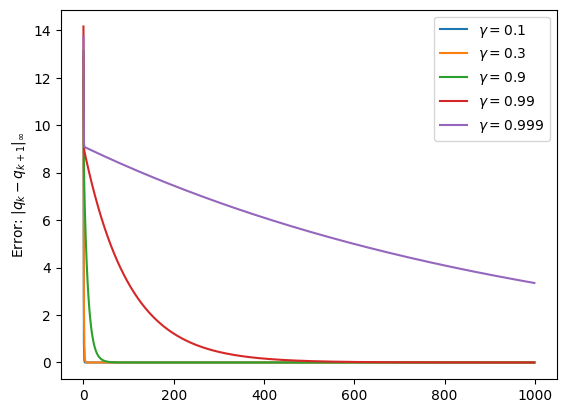

In [55]:
import matplotlib.pyplot as plt

# ベルマン最適作用素の実験
S, A = mdp.S, mdp.A

gammas = [0.1, 0.3, 0.9, 0.99, 0.999]
for gamma in gammas:
    q_before = np.random.randn(S, A)  # Q関数の初期値です
    errors = []

    mdp = mdp._replace(gamma=gamma)
    # ベルマン最適作用素を繰り返し適用して、収束するか確認してみます
    for i in range(1000):
        q_after = Bellman_optimal_operator(mdp, q_before)
        errors.append(np.abs(q_after - q_before).max())
        q_before = q_after

    plt.plot(errors, label=r"$\gamma=$" + f"{gamma}")

plt.ylabel("Error: " + r"$\|q_k - q_{k+1}\|_\infty$")
plt.legend()

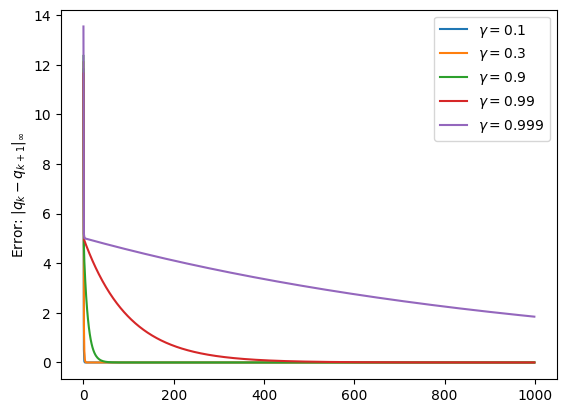

In [56]:
import matplotlib.pyplot as plt

# ベルマン期待作用素の実験
S, A = mdp.S, mdp.A
q = np.random.randn(S, A)  # Q関数の初期値です
pi = np.random.rand(S, A)  # 評価するための適当な方策です
pi = pi / pi.sum(axis=1, keepdims=True)


gammas = [0.1, 0.3, 0.9, 0.99, 0.999]
for gamma in gammas:
    q_before = np.random.randn(S, A)  # Q関数の初期値です
    errors = []

    mdp = mdp._replace(gamma=gamma)
    # ベルマン期待作用素を繰り返し適用して、収束するか確認してみます
    for i in range(1000):
        q_after = Bellman_expected_operator(mdp, q_before, pi)
        errors.append(np.abs(q_after - q_before).max())
        q_before = q_after

    plt.plot(errors, label=r"$\gamma=$" + f"{gamma}")

plt.ylabel("Error: " + r"$\|q_k - q_{k+1}\|_\infty$")
plt.legend()
import matplotlib.pyplot as plt


ちゃんと$\gamma$が大きくなると収束が遅くなる性質が実験できました！

さらに、このベルマン最適作用素が収束しているとき、Q関数は最適Q関数に収束しています。つまり、ベルマン最適作用素をくりかえせば、「MDPを解く」が簡単に達成できるわけですね。

収束した！


Text(0.5, 1.0, 'Converged Q function (optimal Q)')

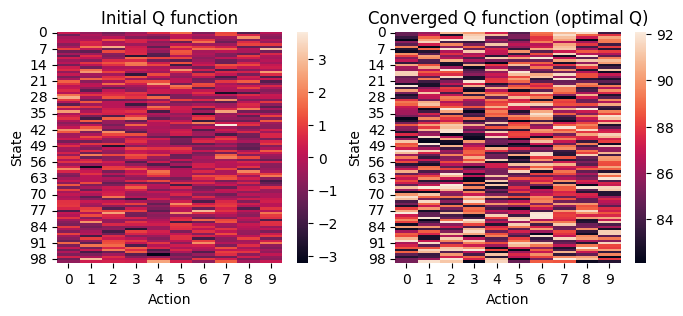

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

S, A = mdp.S, mdp.A
q_init = np.random.randn(S, A)  # Q関数の初期値です
q_before = q_init.copy()
errors = []
mdp = mdp._replace(gamma=0.9)  # gamma == 0.9で試してみます

# ベルマン最適作用素を繰り返し適用して、収束したらそれが最適Q値です。
for i in range(1000):
    q_after = Bellman_optimal_operator(mdp, q_before)
    error = np.abs(q_after - q_before).max()
    if error < 1e-3:
        print("収束した！")
        break
    q_before = q_after

q_star = q_before

# Q関数はSxAの２次元なので、せっかくだから描画してみます
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
sns.heatmap(q_init)
plt.xlabel("Action")
plt.ylabel("State")
plt.title("Initial Q function")

plt.subplot(1, 2, 2)
sns.heatmap(q_star)
plt.xlabel("Action")
plt.ylabel("State")
plt.title("Converged Q function (optimal Q)")

今回は行列形式で動的計画法の実装を確認しました。練習として、自分の力で次の論文たちを実装してみてください。

* [Leverage the Average: an Analysis of KL Regularization in RL](https://arxiv.org/abs/2003.14089)
* [Theoretical Analysis of Efficiency and Robustness of Softmax and Gap-Increasing Operators in Reinforcement Learning](https://proceedings.mlr.press/v89/kozuno19a.html)

Pがわからない場合は今回の行列形式はどうなるでしょうか?以下が参考になります：

* [Generalized Markov Decision Processes: Dynamic-programming and Reinforcement-learning Algorithms](https://sites.ualberta.ca/~szepesva/papers/gmdp.ps.pdf)
* Generalized Markov Decision Processを実装したやつ: [generalized_RL.ipynb](generalized_RL.ipynb)
